## Imports and Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Function Definitions

In [3]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [5]:
def output_spectrum_a(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β):
    """
    Function for calculation the output spectrum from port 1 (i.e. reflection) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * (κ * γ * nT + κ * ϕ)
    b = κ * r * g ** 2 * nc
    c = np.abs(((κ - γ - ϕ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = np.abs(((κ - γ - ϕ) / 2 - 1j * Δ) * r / 2 - g ** 2) ** 2 
    snd_term_den = np.abs(((κ + γ + ϕ) / 2 + 1j * Δ) * r / 2 + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # return
    return num / den + snd_term

In [6]:
def output_spectrum_e(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β):
    """
    Function for calculation the output spectrum from port 2 (i.e. transmission) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * ϕ * (κ + γ) * nT
    b = ϕ * r * g ** 2 * nc
    c = np.abs(((ϕ - κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = ϕ * κ * r ** 2
    snd_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 + 1j * Δ) * r / 2 + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # return
    return num / den + snd_term

In [7]:
def output_spectrum_a_no_nv(ω, κ, γ, ϕ, Δ, nT, β):
    """
    Function for calculation the output spectrum from port 1 (i.e. reflection) using input/output theory with a coherent input source
    and no NV ensemble
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = κ * γ * nT + κ * ϕ
    b = np.abs((κ - γ - ϕ) / 2 + 1j * (ω - Δ)) ** 2 * nT
    num = a + b

    # Define the denominator of the first term
    den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2

    # Define the second term
    snd_term_num = np.abs((κ - γ - ϕ) / 2 - 1j * Δ) ** 2 
    snd_term_den = np.abs((κ + γ + ϕ) / 2 + 1j * Δ) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # return
    return num / den + snd_term

In [8]:
def output_spectrum_e_no_nv(ω, κ, γ, ϕ, Δ, nT, β):
    """
    Function for calculation the output spectrum from port 2 (i.e. transmission) using input/output theory with a coherent input source
    and no NV ensemble
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ϕ * (κ + γ) * nT
    b = np.abs((ϕ - κ - γ) / 2 + 1j * (ω - Δ)) ** 2
    num = a + b

    # Define the denominator of the first term
    den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2

    # Define the second term
    snd_term_num = ϕ * κ
    snd_term_den = np.abs((κ + γ + ϕ) / 2 + 1j * Δ) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # return
    return num / den + snd_term

## Initial Testing

In [9]:
# First define the usual parameters - we'll start at room temperature for now
ωc = 2.87 * 2 * np.pi * 1e9
g = 2 * np.pi * 197.7e3
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)

First test is to see if we can successfully recreate the output spectrum plot if we have 0 extra input

In [10]:
# Define the values of ω and Δ that we need
ω = np.linspace(-1.5, 1.5, 1000) * 2 * np.pi * 1e6
Δ = np.linspace(-4, 4, 1000) * 2 * np.pi * 1e6

# Create the meshgrid
ωm, Δm = np.meshgrid(ω, Δ)

In [11]:
# Now calculate the output spectrum
output_spec = output_spectrum_a(ωm, κ, γ, 0, r, g, Δm, nT, nc, 0)

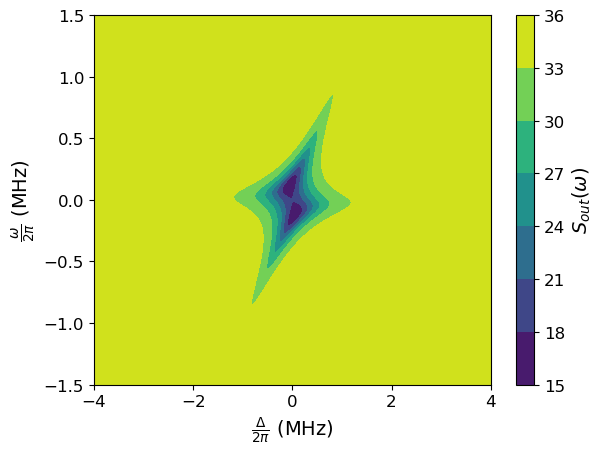

In [12]:
# And plot
plt.contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_spec)
plt.xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
plt.ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.colorbar(label="$S_{out}(\\omega)$")

Now calculate the output spectrum of both ports

In [13]:
# Define the port 2 coupling as the average of the other two damping rates
ϕ = (κ + γ) / 2

In [14]:
# Calculate the output spectra
output_1 = output_spectrum_a(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, 0)
output_2 = output_spectrum_e(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, 0)

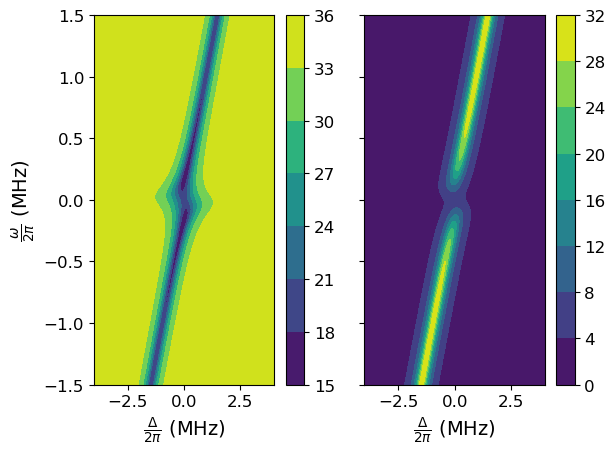

In [15]:
# Plot the results
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharex='all', sharey='all')
im1 = ax[0].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_1)
ax[0].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
ax[0].set_ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
fig.colorbar(im1)

im2 = ax[1].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_2)
ax[1].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
fig.colorbar(im2)

Now what if we add a coherent drive?

In [16]:
# Define the average number of photons in the coherent input
coh_n = 100
β = np.sqrt(coh_n)

In [17]:
# Calculate the output spectra
output_1 = output_spectrum_a(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, β)
output_2 = output_spectrum_e(ωm, κ, γ, ϕ, r, g, Δm, nT, nc, β)

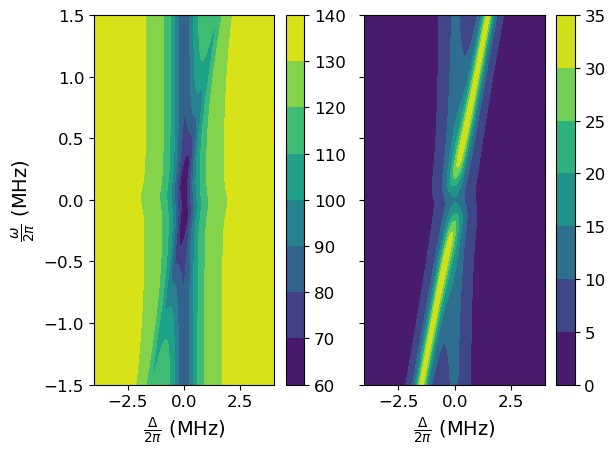

In [18]:
# Plot the results
fig = plt.figure(1)
ax = fig.subplots(1, 2, sharex='all', sharey='all')
im1 = ax[0].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_1)
ax[0].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
ax[0].set_ylabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
fig.colorbar(im1)

im2 = ax[1].contourf(Δm / (2 * np.pi * 1e6), ωm / (2 * np.pi * 1e6), output_2)
ax[1].set_xlabel("$\\frac{\\Delta}{2\\pi}$ (MHz)")
fig.colorbar(im2)

What if we look at 0 detuning?

In [19]:
# Calculate the output spectra
output_1 = output_spectrum_a(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_2 = output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
test = output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, 0)

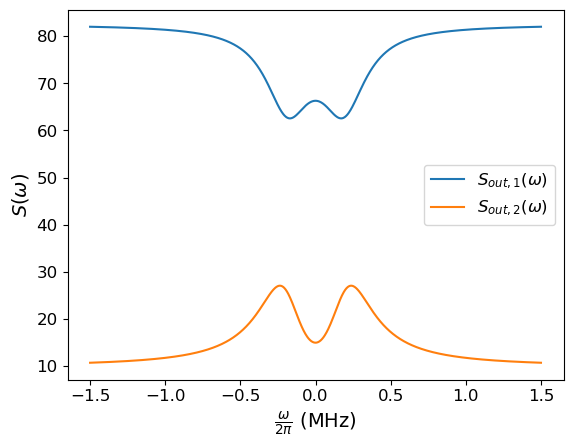

In [20]:
# Plot the results
plt.plot(ω / (2 * np.pi * 1e6), output_1, label='$S_{out,1}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_2, label='$S_{out,2}(\\omega)$')
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

As a check, we can turn off the NV ensemble and the internal loss rate of the cavity.  Then the only input would be the vacuum noise on port 2 and the thermal noise and coherent input on port 1.

In [21]:
# Calculate the output spectra
output_1 = output_spectrum_a_no_nv(ω, κ, 0, ϕ, 0, nT, β)
output_2 = output_spectrum_e_no_nv(ω, κ, 0, ϕ, 0, nT, β)

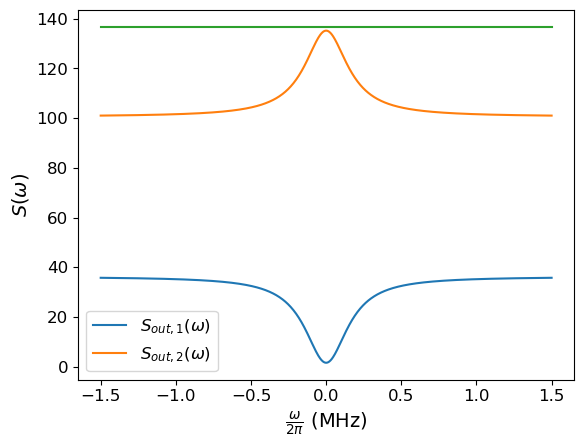

In [22]:
# Plot the results
plt.plot(ω / (2 * np.pi * 1e6), output_1, label='$S_{out,1}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_2, label='$S_{out,2}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_1 + output_2)
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

In [23]:
(output_1 + output_2)[0] / (nT + 1 + np.abs(β) ** 2)

np.float64(1.0)

So the ratio of the sum of the outputs to the sum of the inputs is 1 as expected.  

Adding back in the internal loss rate, we should only be able to get the same ratio if we include another output term $b_{out}$.

In [24]:
def output_spectrum_c_no_nv(ω, κ, γ, ϕ, Δ, nT, β):
    """
    Function for calculation the output spectrum from port 3 (i.e. internal loss) using input/output theory with a coherent input source
    and no NV ensemble
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = γ * κ * nT + γ * ϕ
    b = np.abs((γ - κ - ϕ) / 2 + 1j * (ω - Δ)) ** 2 * nT
    num = a + b

    # Define the denominator of the first term
    den = np.abs((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) ** 2

    # Define the second term
    snd_term_num = γ * κ
    snd_term_den = np.abs((κ + γ + ϕ) / 2 + 1j * Δ) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # return
    return num / den + snd_term

In [25]:
# Calculate the output spectra
output_1 = output_spectrum_a_no_nv(ω, κ, γ, ϕ, 0, nT, β)
output_2 = output_spectrum_e_no_nv(ω, κ, γ, ϕ, 0, nT, β)
output_3 = output_spectrum_c_no_nv(ω, κ, γ, ϕ, 0, nT, β)

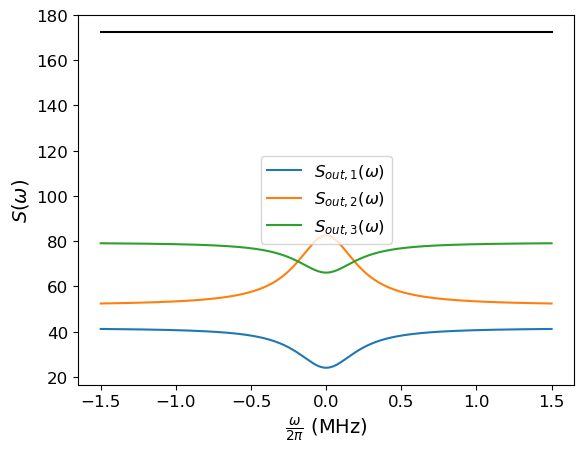

In [26]:
# Plot the results
plt.plot(ω / (2 * np.pi * 1e6), output_1, label='$S_{out,1}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_2, label='$S_{out,2}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_3, label='$S_{out,3}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_1 + output_2 + output_3, color='k')
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

In [27]:
(output_1 + output_2 + output_3)[0] / (2*nT + 1 + np.abs(β) ** 2)

np.float64(0.9999999999999999)

So this confirms my hypothesis!  Adding back in the NV ensemble should provide the same ratio if we also include an expression for $c_{out}$.  That might be a bit overkill, however.  We should be able to determine the ratio of the input that is reflected or transmitted or lost just using the spectra we have and the fact that we have a total input of $2n_T + n_c + 1 + |\beta|^2$.  Would still be useful to have as a check though

In [28]:
def output_spectrum_b(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β):
    """
    Function for calculation the output spectrum from b_out using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = ((r ** 2 / 4) + ω ** 2) * (κ * γ * nT + γ * ϕ)
    b = γ * r * g ** 2 * nc
    c = np.abs(((γ - κ - ϕ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 * nT
    num = a + b + c

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = r ** 2 * γ * κ 
    snd_term_den = 4 * np.abs(((κ + γ + ϕ) / 2 + 1j * Δ) * r / 2 + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # return
    return num / den + snd_term

In [29]:
def output_spectrum_c(ω, κ, γ, ϕ, r, g, Δ, nT, nc, β):
    """
    Function for calculation the output spectrum from c_out (into ensemble) using input/output theory with a coherent input source
    :param ω:  the frequency
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the inhomogenous spreading of the spins
    :param g:  the coupling strength between the cavity and the spin ensemble
    :param Δ:  the detuning between the cavity and the spins
    :param nT: the number of thermal photons in the cavity
    :param nc: the effective number of photons in the spin bath
    :param β:  the amplitude of the coherent state <n> = |β|^2
    :return:   the output spectrum (photons / freq)
    """
    # Define the terms of the numerator of the first term
    a = r * κ * g ** 2 * nT + r * γ * g ** 2 * nT + r * ϕ * g ** 2
    b = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 + 1j * ω) - g ** 2) ** 2 * nc
    num = a + b

    # Define the denominator of the first term
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # Define the second term
    snd_term_num = g ** 2 * r * κ 
    snd_term_den = np.abs(((κ + γ + ϕ) / 2 + 1j * Δ) * r / 2 + g ** 2) ** 2
    snd_term = snd_term_num / snd_term_den * np.abs(β) ** 2

    # return
    return num / den + snd_term

In [30]:
output_a = output_spectrum_a(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_e = output_spectrum_e(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_b = output_spectrum_b(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)
output_c = output_spectrum_c(ω, κ, γ, ϕ, r, g, 0, nT, nc, β)

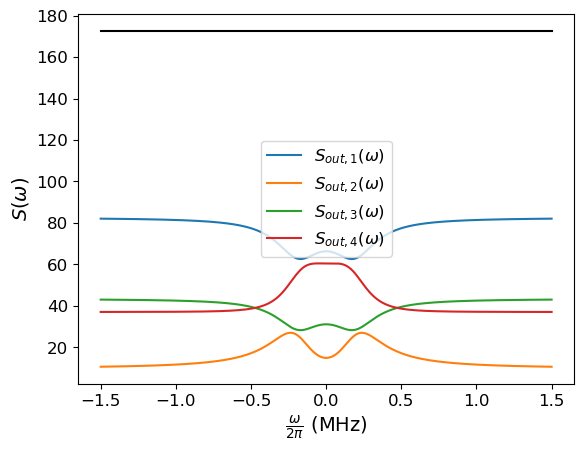

In [31]:
# Plot the results
plt.plot(ω / (2 * np.pi * 1e6), output_a, label='$S_{out,1}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_e, label='$S_{out,2}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_b, label='$S_{out,3}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_c, label='$S_{out,4}(\\omega)$')
plt.plot(ω / (2 * np.pi * 1e6), output_a + output_e + output_b + output_c, color='k')
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S(\\omega)$")
plt.legend()

In [32]:
(output_a + output_e + output_b + output_c)[0] / (2 * nT + 1 + nc + np.abs(β) ** 2)

np.float64(1.0)

So this works as well!

Now I suppose that we can try to estimate the attenutation in the input signal.  The initial situation is
$|\beta|^2 / (2n_T + n_c + 1 + |\beta|^2)$.  The output we're interested in is just output_e, so we have output_e over the same denominator (I think?).

Text(0, 0.5, '$S_{out,2}(\\omega)$/Initial')

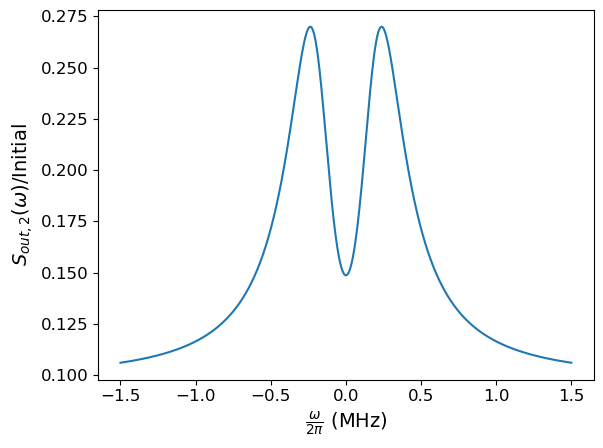

In [33]:
initial = np.abs(β) ** 2 / (2 * nT + 1 + nc + np.abs(β) ** 2)
final = output_e / (2 * nT + 1 + nc + np.abs(β) ** 2)
plt.plot(ω / (2 * np.pi * 1e6), final / initial)
plt.xlabel("$\\frac{\\omega}{2\\pi}$ (MHz)")
plt.ylabel("$S_{out,2}(\\omega)$/Initial")

Kurt suggested that we should be able to look at the noise and signal terms and compare how they've changed after transmission through the cavity to determine how much the SNR has changed.

In [35]:
def output_noise(ω, κ, γ, ϕ, r, g, nT, nc, Δ):
    # The denonminator doesn't change, so we can start by defining that
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    # There are 4 noise terms
    noise_a = (r ** 2 / 4 + ω ** 2) * ϕ * κ * nT / den
    noise_b = (r ** 2 / 4 + ω ** 2) * ϕ * γ * nT / den
    noise_c = ϕ * r * g ** 2 * nc / den
    noise_e = np.abs(((ϕ - κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) - g ** 2) ** 2 / den

    return noise_a + noise_b + noise_c + noise_e

In [36]:
def output_signal(ω, κ, γ, ϕ, r, g, Δ, β):
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j * ω) + g ** 2) ** 2

    return ϕ * κ * r ** 2 * np.abs(β) ** 2 / (4 * den)

In [38]:
# Let's assume for now that we're on resonance so that ω = 0 = Δ
input_s = np.abs(β) ** 2
output_s = output_signal(0, κ, γ, ϕ, r, g, 0, β)
print("Input Signal: ", input_s)
print("Output Signal: ", output_s)
print("Ratio: ", output_s / input_s)

Input Signal:  100.0
Output Signal:  8.786432886433149
Ratio:  0.08786432886433149


In [40]:
# Now the noise
input_n = nT
output_n = output_noise(0, κ, γ, ϕ, r, g, nT, nc, 0)
print("Input Noise: ", input_n)
print("Output Noise: ", output_n)
print("Ratio: ", output_n / input_n)

Input Noise:  35.79937923012842
Output Noise:  6.086687087471832
Ratio:  0.1700221405612903


In [41]:
print("Initial SNR: ", input_s / input_n)
print("Final SNR: ", output_s / output_n)

Initial SNR:  2.7933445258134793
Final SNR:  1.4435493003276243
